# 1. Get data

In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()

In [ ]:
# Setting up Kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# Download dataset
! kaggle competitions download -c dogs-vs-cats

# Unzip dataset
! unzip dogs-vs-cats.zip
! unzip train.zip
! unzip test1.zip

In [ ]:
! rm -rf dogs-vs-cats.zip train.zip test1.zip

In [ ]:
import os
import cv2
import copy
import tqdm
import glob
import torch
import random
import zipfile
import numpy as np
import torchvision
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from typing import Tuple, Dict, List
from timeit import default_timer as timer
from sklearn.model_selection import train_test_split
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset, ConcatDataset

In [ ]:
torch.__version__

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(42)
if device == "cuda":
  torch.cuda.manual_seed(42)

device

# 2. Data preration and data exploratioin

**Visaulizing an image**

In [ ]:
# Load train and test data
train_dir = "train"
test_dir = "test1"

train_list = glob.glob(os.path.join(train_dir, "*.jpg"))
test_list = glob.glob(os.path.join(test_dir, "*.jpg"))

Image class: cat
Image height: 393
Image width: 499


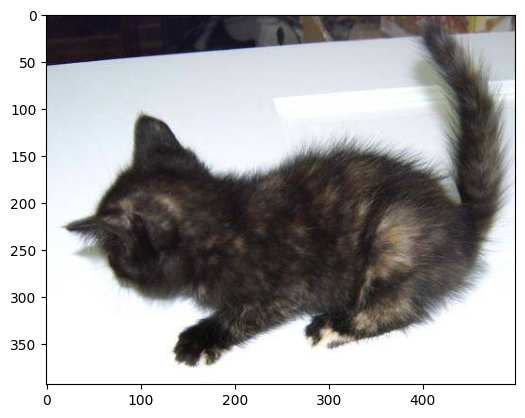

In [ ]:
def plot_image(train_images: list):
  """Plots a random image.

  Args:
    train_images (list): List of image paths.

  Returns:
    None
  """
  # Get a random image index
  index = random.randint(0, len(train_images))
  # Get the image path
  image_path = train_images[index]
  # Open the image
  with Image.open(image_path) as f:
    # Plot the image
    plt.imshow(f)
    # Print the image class
    print(f"Image class: {os.path.basename(image_path).split('.')[0]}")
    print(f"Image height: {f.height}")
    print(f"Image width: {f.width}")

plot_image(train_list)

In [ ]:
train_list[0].split("/")[-1].split(".")[0]

'dog'

**Visualizating Transforming images**

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
img = Image.open(train_list[0])

print(f"Original size: {img.mode} {img.size}")
print(f"\nTransformed size: {data_transform(img).shape}")

Original size: RGB (358, 269)

Transformed size: torch.Size([3, 224, 224])


In [ ]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """Original Vs transformed images

  Selects random images from a path of images and loads/transforms
  them then plots the original vs the transformed version.

  Args:
    image_paths (list): List of image paths.
    transform (torchvision.transforms): Image transform.
    n (int, optional): Number of images to plot. Defaults to 3.
    seed (int, optional): Random seed. Defaults to None.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    image_path = Path(image_path)  # Convert to Path object
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")
      fig.suptitle(f"Class: {os.path.basename(image_path).split('.')[0]}", fontsize=16)

In [ ]:
plot_transformed_images(image_paths=train_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

# 3. Loading image data using `ImageFolder`

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
class dataset(torch.utils.data.Dataset):
    def __init__(self, file_list, transform = None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0

        return img_transformed, label

In [ ]:
train_list, val_list = train_test_split(train_list, test_size=0.3, random_state=42)

In [ ]:
train_data = dataset(train_list, transform=transform)
val_data = dataset(val_list, transform=transform)
test_data = dataset(test_list, transform=transform)

In [ ]:
BATCH_SIZE = 100
train_dataloader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)
val_dataloader = torch.utils.data.DataLoader(dataset=val_data,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

In [ ]:
train_dataloader, val_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a2060996b60>,
 <torch.utils.data.dataloader.DataLoader at 0x7a20609958a0>)

In [ ]:
print(len(train_data), len(train_dataloader))
print(len(val_data), len(val_dataloader))
print(len(test_data), len(test_dataloader))

17500 175
7500 75
12500 125


In [ ]:
train_data[0][0].shape

torch.Size([3, 224, 224])

# 4. Model

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)

        )

        # Explain these: https://chatgpt.com/share/8f6e3576-d14e-4c43-b8e8-1d360053cbf1
        self.fc1 = nn.Linear(3 * 3 * 64, 10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = x.view(x.size(0), -1)
      x = self.relu(self.fc1(x))
      x = self.fc2(x)
      return x

In [ ]:
# Instantiate an instance of the model
model = CNN().to(device)
model

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(

In [ ]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and usqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
  pred = model(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n {pred}\n")
print(f"Output prediction probabilities:\n {torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n {torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n {label_single}")

# 5. Create `train_step()` and `test_step()` function and `train()` to combine them

In [ ]:
# train_step(): takes in a model and dataloader and trains the model on the dataloader.
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device = device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: Target PyTorch model to be trained
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function.
    optimizer: A PyTorch optimizer to help minimize teh boss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:
    (0.1112, 0.8743)
  """
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # output model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [ ]:
# test_step(): takes in a model and dataloader and evaluates the model on the dataloader.
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device = device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A Pytorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of test loss and test accuracy metrics.
    In the form (test_loss, test_accuracy). For example:
    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjut metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [ ]:
# Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device,
          patience: int = 5,
          delta: float = 0.0) -> Dict[str, List[float]]:
  """Trains and tests a PyTorch model with early stopping.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model in
  the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args.
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: An Optimizer instance for the model to be trained with.
    loss_fn: A PyTorch loss function to be used for training. Defaults to nn.CrossEntropyLoss().
    epochs: The number of epochs to train and test the model for. Defaults to 5.
    device: A target device to compute on. Defaults to "cuda" if available, else "cpu".

  Returns:
    A dictionary of training and testing metrics loss as well as training and
    testing accuracy metrics.
    In the form of a dictionary:
                  {train_loss: [],
                  train_acc: [],
                  test_loss: [],
                  test_acc: []}
    For example if training for epochs = 2:
                  {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]}

  """
  # Initialize early stopping variables
  best_val_loss = float('inf')
  epochs_no_improve = 0
  early_stop = False

  # Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    if not early_stop:
      train_loss, train_acc = train_step(model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device)
      test_loss, test_acc = test_step(model=model,
                                      dataloader=train_dataloader,
                                      loss_fn=loss_fn,
                                      device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch} | "
          f"Train loss: {train_loss:.4f} | "
          f"Train acc: {train_acc:.4f} | "
          f"Test loss: {test_loss:.4f} | "
          f"Test acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

      # Chech if validation loss has improved
      if test_loss < best_val_loss - delta:
        best_val_loss = test_loss
        epochs_no_improve = 0
      else:
        epochs_no_improve += 1

      # Chech early stopping condition
      if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch}.")
        early_stop = True

  # Return the filled results at the end of the epochs
  return results

# 6. Train, evaluate and save the model

**Function to save the model to a directory**

In [ ]:
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Save a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for saving the model. Should include
      either ".pth" or ".pt" as the file extension.

  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model.name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

**Train the model**

In [ ]:
"""
epochs = 10

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = loss_fn(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = ((output.argmax(dim=1)==label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)

    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy, epoch_loss))

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data,label in val_loader:
            data= data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = loss_fn(output,label)

            acc = ((output.argmax(dim=1)==label).float().mean())
            epoch_val_accuracy += acc/len(val_loader)
            epoch_val_loss += val_loss/len(val_loader)
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))

"""
print()

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 50

model = CNN().to(device)

# Define loss function and optimize
"""
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
"""
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Start the timer
start_time = timer()

# Train model_0
model_results = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print ouut how long it took
end_time = timer()
print(f"\n[INFO] Total training time: {end_time-start_time:.3f} seconds\n")

# Save the model
save_model(model=model,
           target_dir="models",
           model_name="cnn_50_epochs_model.pth")

**Plot the loss curves of Model**

In [ ]:
model_results.keys()

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how mnay epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

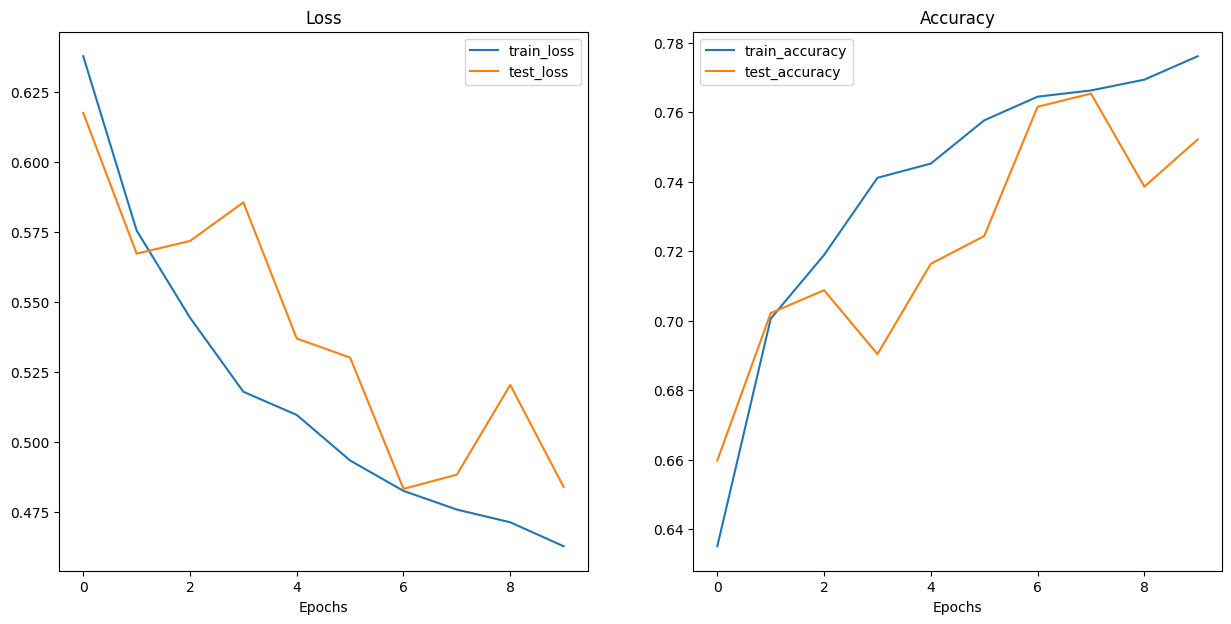

In [ ]:
plot_loss_curves(model_results)

# 7. Submission

In [ ]:
dog_probs = []
model.eval()
with torch.no_grad():
  for data, fileid in test_loader:
    data = data.to(device)
    preds = model(data)
    preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
    dog_probs += list(zip(list(fileid), preds_list))

In [ ]:
dog_probs.sort(key = lambda x: int(x[0]))
dog_probs

In [ ]:
idx = list(map(lambda x :x[0],dog_probs))
prob = list(map(lambda x :x[1],dog_probs))

In [ ]:
submission = pd.DataFrame({'id':idx, 'label':prob})

In [ ]:
submission

,id,label
0,1,0.797096
1,2,0.966528
2,3,0.484862
3,4,0.999705
4,5,0.086005
...,...,...
12495,12496,0.051373
12496,12497,0.226809
12497,12498,0.219581
12498,12499,0.963138


In [ ]:
pd.read_csv("sampleSubmission.csv")

,id,label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
12495,12496,0
12496,12497,0
12497,12498,0
12498,12499,0


In [ ]:
submission.to_csv('result.csv',index=False)

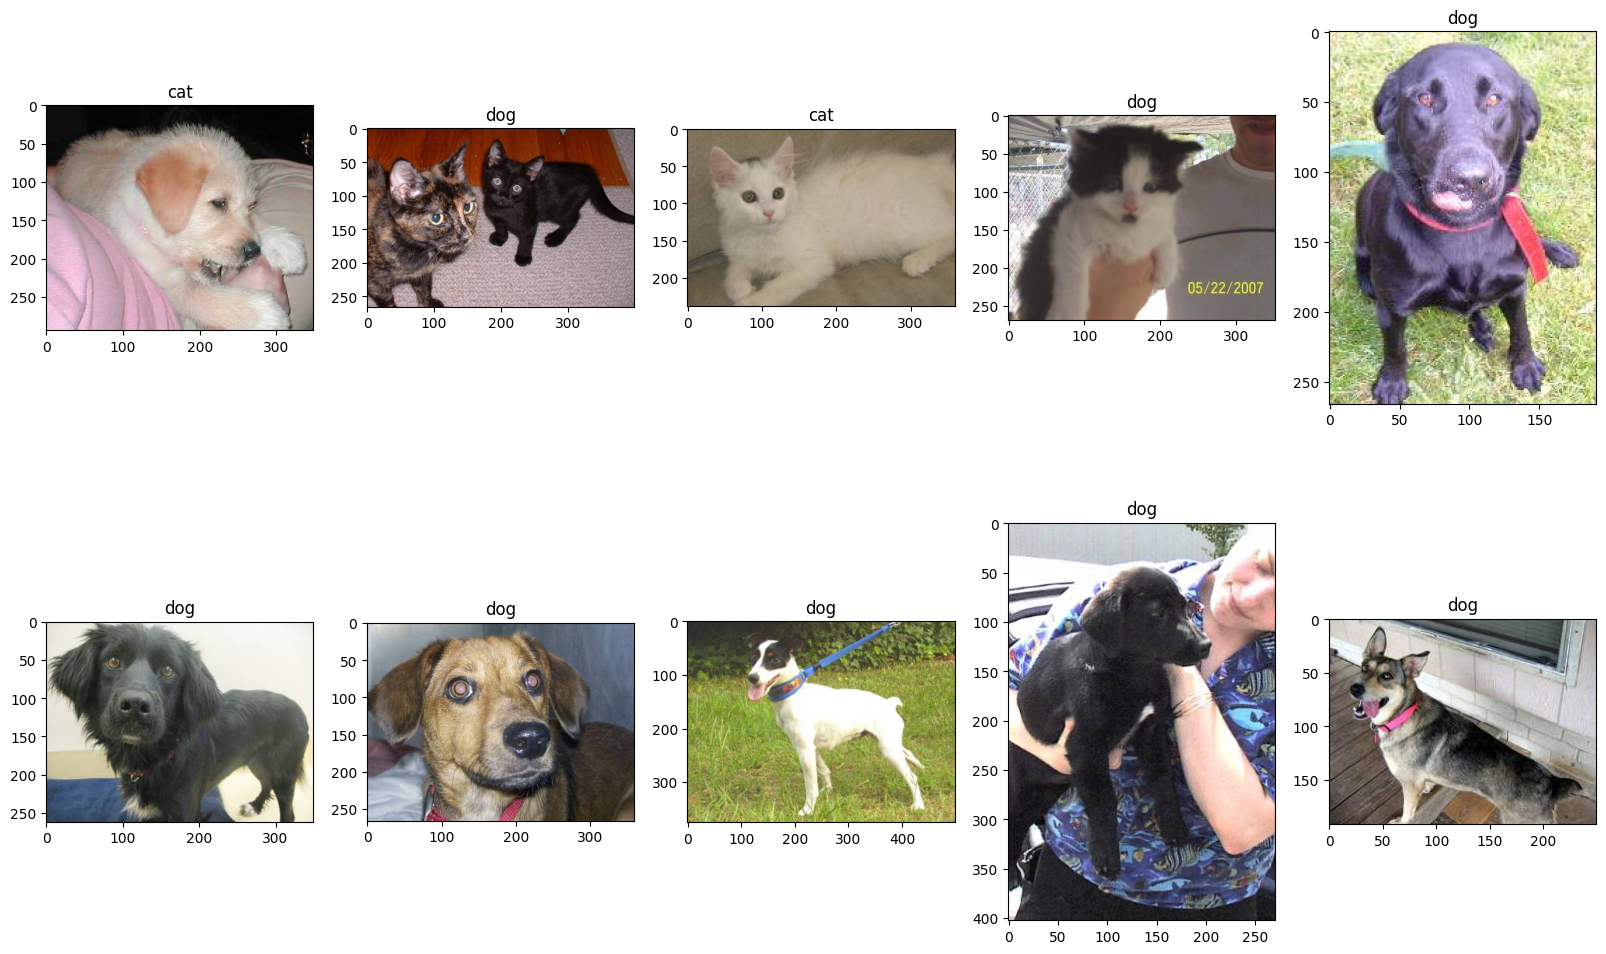

In [ ]:
id_list = []
class_ = {0: 'cat', 1: 'dog'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():

    i = random.choice(submission['id'].values)

    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0

    img_path = os.path.join(test_dir, '{}.jpg'.format(i))
    img = Image.open(img_path)

    ax.set_title(class_[label])
    ax.imshow(img)